In [1]:
# git clone repo để lấy data
!git clone https://github.com/lamtai2508/LNHONGTAI_DATA_ANALYTICS_SGU_2025.git

Cloning into 'LNHONGTAI_DATA_ANALYTICS_SGU_2025'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 29 (delta 6), reused 24 (delta 4), pack-reused 0 (from 0)
Receiving objects: 100% (29/29), 21.90 MiB | 12.71 MiB/s, done.
Resolving deltas: 100% (6/6), done.


# Cây quyết định và rừng cây

2.1.3 Bài thực hành số 1: Xây dựng cây quyết định và rừng cây trên dữ liệu Titanic

Dữ liệu lấy tại: https://www.kaggle.com/code/dmilla/introduction-to-decision-trees-titanic-dataset

Mục tiêu hướng tới: xây dựng cây quyết dịnh và rừng cây để dự đoán hành khách sống hay không.

Bước 1: import những thư viện sẽ sử dụng

In [16]:
# import các thư viện
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import matplotlib as mpl
import graphviz

Bước 2: chuẩn bị dữ liệu

In [4]:
# Nạp dữ liệu Titanic
df = pd.read_csv('/content/LNHONGTAI_DATA_ANALYTICS_SGU_2025/Data_Sets/train.csv')
print("Kích thước dữ liệu:", df.shape)

# Loại bỏ cột không cần thiết
df = df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])

# Xử lý dữ liệu thiếu
df = df.dropna(subset=['Age', 'Embarked'])

# Chuyển đổi dữ liệu phân loại sang số
df['Sex'] = df['Sex'].map({'male': 1, 'female': 0})
df['Embarked'] = df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})

# Tách biến độc lập (X) và phụ thuộc (y)
X = df.drop(columns=['Survived'])
y = df['Survived']

Kích thước dữ liệu: (891, 12)


Bước 3: chuẩn bị dữ liệu cho tập train và test để vẽ cây quyết định

In [5]:
# Chia tập train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

Bước 4: xây dựng cây quyết định từ lớp DecisionTreeClassifier có trong thư viện Scikit-Learn

In [28]:
# Huấn luyện DecisionTree most là 3
tree_model = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2, random_state=42)

Bước 5: hiện thị cây quyết định

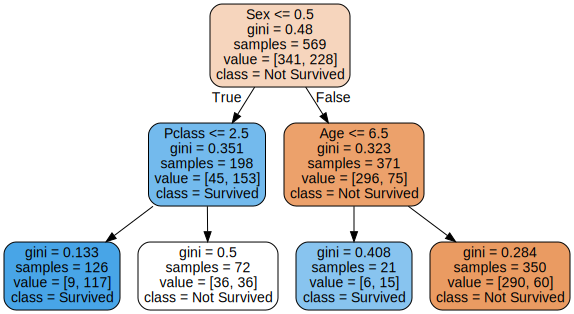

In [29]:
# Vẽ cây quyết định
dot_data = export_graphviz(
    tree_model,
    out_file=None,
    feature_names=X.columns,
    class_names=['Not Survived', 'Survived'],
    filled=True,
    rounded=True
)
graph = graphviz.Source(dot_data)
graph.render("titanic_tree", format="png", cleanup=True)
graph

Bước 6: Vẽ biểu đồ đánh giá mô hình với các tham số chiều sâu của cây khác nhau

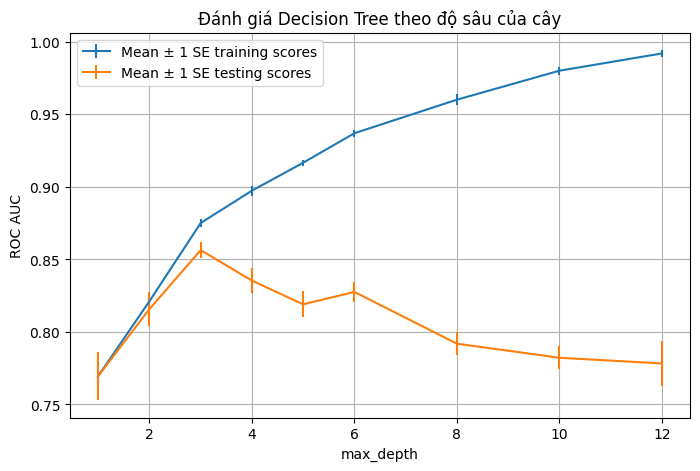

In [27]:
# Tạo cây quyết định và xác định các giá trị tham số có thể chọn để tìm tham số tối ưu
params = {'max_depth': [1, 2, 3, 4, 5, 6, 8, 10, 12]}
dt = DecisionTreeClassifier(random_state=42)

cv = GridSearchCV(
    dt,
    param_grid=params,
    scoring='roc_auc',
    cv=4,
    return_train_score=True,
    verbose=0
)
cv.fit(X_train, y_train)

cv_results_df = pd.DataFrame(cv.cv_results_) # lưu kết quả vào DataFrame

# Vẽ biểu đồ đánh giá các tham số chiều sâu của cây khác nhau
plt.figure(figsize=(8, 5))
ax = plt.axes()
ax.errorbar(cv_results_df['param_max_depth'],
             cv_results_df['mean_train_score'],
             yerr=cv_results_df['std_train_score']/np.sqrt(4),
             label='Mean ± 1 SE training scores')
ax.errorbar(cv_results_df['param_max_depth'],
             cv_results_df['mean_test_score'],
             yerr=cv_results_df['std_test_score']/np.sqrt(4),
             label='Mean ± 1 SE testing scores')
ax.legend()
plt.xlabel('max_depth')
plt.ylabel('ROC AUC')
plt.title('Đánh giá Decision Tree theo độ sâu của cây')
plt.grid(True)
plt.show()

# Thực hiện xây dựng rừng cây

Bước 1,2,3: import các thư viện để sử dựng và chuẩn bị dữ liệu, do đã làm thực hiện ở trên để vẽ cây quyết định nên không cần làm lại

Bước 4: Huận luyện RandomForestClassifier trong Scikit-Learn

In [9]:
# 🔟 Huấn luyện Random Forest
rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42) # dùng 100 cây quyết định với độ sâu là 5
rf_model.fit(X_train, y_train) # X,y đã được định dạng trước để code trong gọn hơn

RandomForestClassifier(max_depth=5, random_state=42)

Bước 5: Tìm tham số tối ưu cho mô hình rừng cây và thực hiện train với tham số tối ưu đó

In [30]:
#
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [3, 5, 7, 9, None],
    'min_samples_split': [2, 5, 10]
}
rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='accuracy',
    cv=4,
    verbose=1,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

# 3️⃣ Lưu kết quả vào DataFrame
grid_search_results_df = pd.DataFrame(grid_search.cv_results_)

print("\n Tham số tối ưu:", grid_search.best_params_)
print("Độ chính xác cao nhất:", grid_search.best_score_)

Fitting 4 folds for each of 60 candidates, totalling 240 fits

 Tham số tối ưu: {'max_depth': 9, 'min_samples_split': 5, 'n_estimators': 100}
Độ chính xác cao nhất: 0.8242391411405496


Bước 6: Vẽ biểu đồ đánh giá mô hình rừng cây với các tham số số cây có trong rừng khác nhau

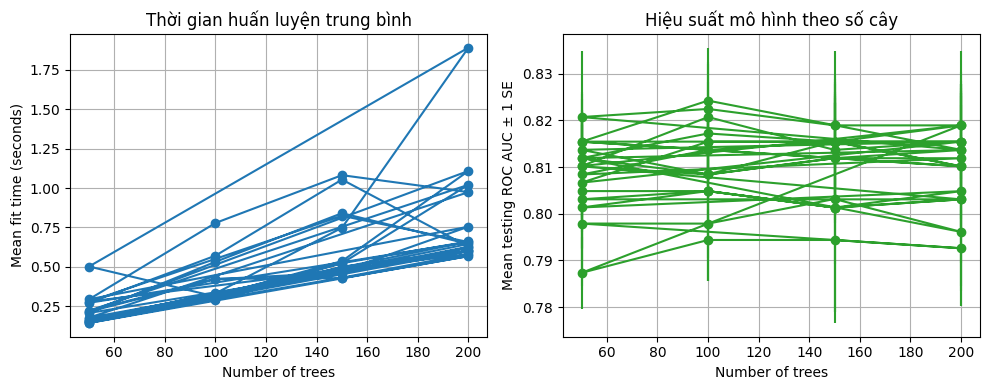

In [20]:
# Vẽ biểu đồ với 2 subplot (giống yêu cầu)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# Biểu đồ 1: Thời gian huấn luyện trung bình
axs[0].plot(grid_search_results_df['param_n_estimators'],
            grid_search_results_df['mean_fit_time'],
            '-o', color='tab:blue')
axs[0].set_xlabel('Number of trees')
axs[0].set_ylabel('Mean fit time (seconds)')
axs[0].set_title('Thời gian huấn luyện trung bình')
axs[0].grid(True)

# Biểu đồ 2: Điểm ROC AUC trung bình ± 1 SE
axs[1].errorbar(grid_search_results_df['param_n_estimators'],
                grid_search_results_df['mean_test_score'],
                yerr=grid_search_results_df['std_test_score']/np.sqrt(4),
                fmt='-o', color='tab:green')
axs[1].set_xlabel('Number of trees')
axs[1].set_ylabel('Mean testing ROC AUC ± 1 SE')
axs[1].set_title('Hiệu suất mô hình theo số cây')
axs[1].grid(True)

plt.tight_layout()
plt.show()

Bước 7: Xem tham số tốt nhất của rừng cây, xem mức độ quan trọng của từng feature trong mô hình với tham
số tốt nhất

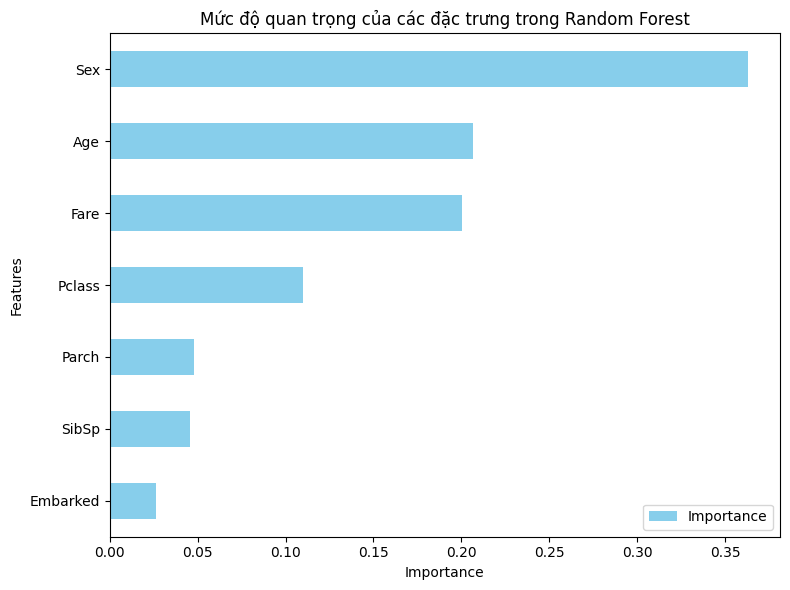

In [23]:
# Tạo DataFrame thể hiện mức độ quan trọng của từng feature
feat_imp_df = pd.DataFrame({
    'Importance': grid_search.best_estimator_.feature_importances_
}, index=X_train.columns)

# Sắp xếp từ cao đến thấp và vẽ biểu đồ mức độ quan trọng
feat_imp_df.sort_values('Importance', ascending=True).plot.barh(
    figsize=(8, 6),
    color='skyblue',
    title='Mức độ quan trọng của các đặc trưng trong Random Forest'
)

plt.xlabel('Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()
